In [14]:
import random

# process monthly precipitation data:

Precip = []

monthly = 18.78383 #(millimeters?)

#need to allocate to the number of days in the month
num_days = 31

for i in range(0, num_days):
    Precip.append(monthly/num_days)
    
T_air = []

monthly = 0.0 #(Celsius)

for i in range(0, num_days):
    T_air.append(monthly/num_days + float(random.randint(-40, 41))/10.0)
    
SWE = [25]

for i in range(0, num_days):
    SWE.append(0)


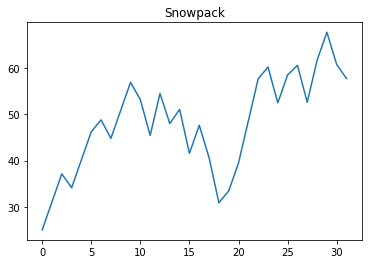

In [15]:
# see: https://www.hec.usace.army.mil/confluence/hmsdocs/hmsguides/modeling-snowmelt/using-the-snowmelt-modeling-capabilities-within-hec-hms

import matplotlib.pyplot as plt

#calculate snowpack based on weather data

#T_air = [0, -2, -2, -5, 0, 0, -12, -14, -8, -7, -10, -2, -3, 0, 1, 5, 4, 2, 8, -1, -2, 4]
#Precip = [0, 2, 12, 6, 0, 0, 12, 14, 28, 27, 10, 2, 3, 0, 11, 5, 4, 12, 8, 1, 2, 4]
#SWE = [50, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

# dSWE = P - R + V + B, where:

# d = change in
# SWE = Snow Water Equivalent
# P = Precipitation contribution (see rain-to-snow multiplier table below)
# R = Run off (determined by phase change in the snowpack which is determined through the energy balance calculations)
# V = mass gained by water Vapor (can be negative)
# B = mass gained by Blowing snow (can be negative)

# The melt rate for dry conditions typically ranges from 1 to 4 mm/degC-day

rain_to_snow = [
   #Tmin, Tmax, multiplier 
    [1, 40, 0],
    [-2.8, 1, 10],
    [-6.7, -2.8, 15],
    [-9.5, -6.7, 20],
    [-12.2, -9.5, 30],
    [-17.8, -12.2, 40],
    [-28.9, -17.8, 50],
    [-60, -28.9, 100]]

for i in range(0, len(Precip)):
    
    P = Precip[i]
    for r in range(0, len(rain_to_snow)):
        if (T_air[i] >= rain_to_snow[r][0]):
            if (T_air[i] < rain_to_snow[r][1]):
                P = Precip[i]*rain_to_snow[r][2]              
    
    R = 0
    if T_air[i] > 0:
        if P == 0:
            R = T_air[i] * 2.5 
        else:
            R = T_air[i] * 5.0

    SWE[i+1] = SWE[i] + P - R

#plot the stock's performance
plt.plot(SWE)
plt.title('Snowpack')

#print(T_air)

plt.show()